# $$\text{Classical Monte Carlo Simulation}$$
## $\text{Triangular Lattice Ising Model}$

- $\text{Name: Utkarsh Maurya}$
- $\text{Roll No.: PH21B012}$

In [11]:
import numba
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Libraries needed: numpy, matplotlib, numba, tqdm   
If the code shows module not found, install the required libraries using example:   
`!pip install numba`

In [12]:
# Numba is a library which supports parallelization, which makes Monte Carlo Simulations Faster

# Neighbours in triangular lattice
@numba.njit
def neighbour(x,i,j):
    n = len(x)
    r = x[i,(j + 1)%n]
    l = x[i,(j - 1)%n]
    u = x[(i - 1)%n,j]
    d = x[(i + 1)%n,j]
    dr = x[(i + 1)%n,(j + 1)%n]
    ul = x[(i - 1)%n,(j - 1)%n]
    return np.array([r,l,u,d,dr,ul])

# Finding Energy of given Lattice
@numba.njit
def Hamiltonian(l, J, B):
    n = len(l)
    s1 = 0
    for i in range(n):
        for j in range(n):
            s1 += l[i][j] * np.sum(neighbour(l, i, j))
    s1 = s1/2
    s2 = np.sum(l)
    return J * s1 - B * s2

# Energy change when [i,j] spin is flipped
@numba.njit
def energy_diff(l,J,B,i,j):
    return -2*J*l[i][j]*np.sum(neighbour(l,i,j)) + 2*B*l[i][j]

# Update Sweep function
@numba.njit
def sweep(l,J,M,B,T):
    N = len(l)
    E = Hamiltonian(l,J,B)
    Ms = np.sum(l)/N**2
    E_arr = []
    M_arr = []
    
    # We run this code M * N**2 times where M is number of thermalization steps and N is grid size
    # Then we take value after each N**2 times using [::N**2]
    for _ in range(M * N**2):
        i, j = np.random.randint(0, N, 2)
        deltaE = energy_diff(l,J,B,i,j)
        p_acc = np.exp(-1*deltaE / T)
        if np.random.random() < p_acc:
            l[i,j] = -1*l[i,j]
            E = E + deltaE
            Ms = Ms + 2*l[i,j]/N**2
        E_arr.append(E)
        M_arr.append(Ms)
    return l,np.array(E_arr[::N**2]),np.array(M_arr[::N**2])

### $\text{(a) Ferromagnetic (J = -1)}$

In [13]:
# Values of constants
n = 10 # Grid Size
J = -1 # For Ferromagnetic, J = -1
B = 0 
T = 1.5 # Temperature 
M = 40000 # Number of Monte Carlo Sweeps

# Defining a random lattice of spins +1 and -1 of grid size n
l = np.random.choice([-1,+1], size = (n,n))

# Run Monte Carlo for given conditions
system = sweep(l,J,M,B,T)

#### $\text{Thermalization of system}$

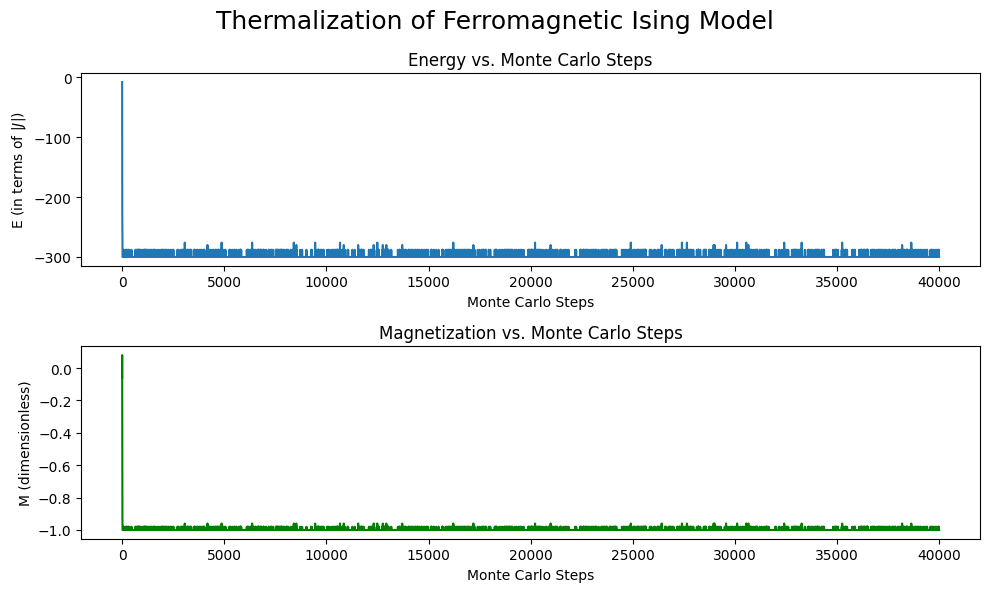

In [14]:
plt.figure(figsize=(10,6))
plt.suptitle('Thermalization of Ferromagnetic Ising Model', fontsize=18)

plt.subplot(211)
plt.plot(system[1],'-')
plt.title('Energy vs. Monte Carlo Steps')
plt.xlabel('Monte Carlo Steps')
plt.ylabel('E (in terms of $|J|$)')

plt.subplot(212)
plt.plot(system[2],'g-')
plt.title('Magnetization vs. Monte Carlo Steps')
plt.xlabel('Monte Carlo Steps')
plt.ylabel('M (dimensionless)')

plt.tight_layout()
plt.show()

#### $\text{Monte Carlo Simulation}$

In [15]:
meanE = lambda E,k:np.mean(E[k:])
meanM = lambda Ms,k:np.mean(Ms[k:])
varE = lambda E,k:np.var(E[k:])
varM = lambda Ms,k:np.var(Ms[k:])

Cv = lambda E,T,k:1/T**2 * np.var(E[k:])
chi = lambda Ms,T,k:1/T * np.var(Ms[k:])

# Temperature range 0.5K to 7K
Ts = np.linspace(0.5,7,75)

meanEnergy1 = []
meanMagnetization1 = []
specific_heat1 = []
susceptibility1 = []

for i in tqdm(range(len(Ts))):
    # Values of constants
    n = 10
    J = -1
    B = 0
    T = Ts[i]
    
    # Total Monte Carlo Simulation Steps = 40000
    M = 40000
    # Taking the values after 20000 steps for thermalization
    k = 20000

    l = np.random.choice([-1,+1], size = (n,n))
    
    res = sweep(l,J,M,B,T)
    E = res[1]
    Ms = np.abs(res[2])
    
    meanEnergy1.append(meanE(E,k))
    meanMagnetization1.append(meanM(Ms,k))
    specific_heat1.append(Cv(E,T,k))
    susceptibility1.append(chi(Ms,T,k))

100%|██████████| 75/75 [01:03<00:00,  1.19it/s]


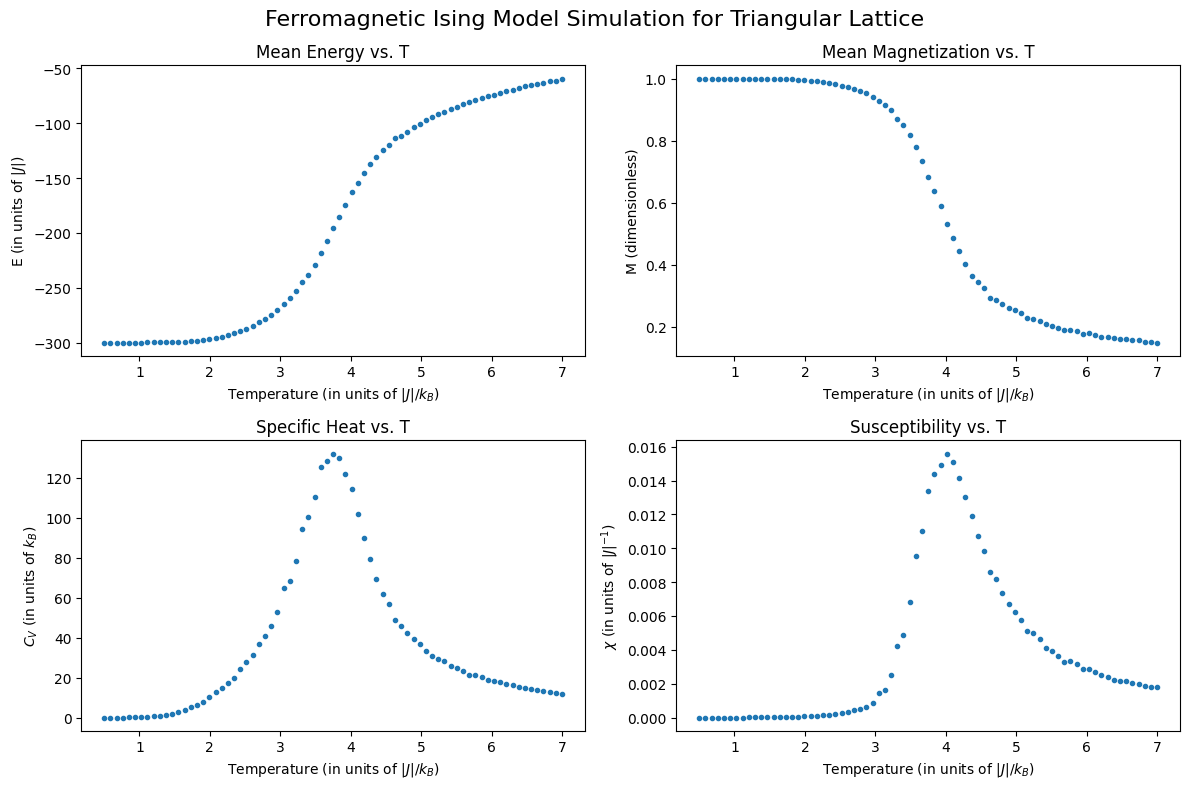

In [16]:
plt.figure(figsize=(12,8))
plt.suptitle("Ferromagnetic Ising Model Simulation for Triangular Lattice", fontsize=16)

plt.subplot(221)
plt.plot(Ts,meanEnergy1,'.')
plt.title('Mean Energy vs. T')
plt.xlabel('Temperature (in units of $|J|/k_B$)')
plt.ylabel('E (in units of $|J|$)')

plt.subplot(222)
plt.plot(Ts,meanMagnetization1,'.')
plt.title('Mean Magnetization vs. T')
plt.xlabel('Temperature (in units of $|J|/k_B$)')
plt.ylabel('M (dimensionless)')


plt.subplot(223)
plt.plot(Ts,specific_heat1,'.')
plt.title('Specific Heat vs. T')
plt.xlabel('Temperature (in units of $|J|/k_B$)')
plt.ylabel('$C_V$ (in units of $k_B$)')


plt.subplot(224)
plt.plot(Ts,susceptibility1,'.')
plt.title('Susceptibility vs. T')
plt.xlabel('Temperature (in units of $|J|/k_B$)')
plt.ylabel('$\chi$ (in units of $|J|^{-1}$)')

plt.tight_layout()
plt.savefig('Ferro.pdf', dpi=300)
plt.show()

### $\text{(b) Anti-Ferromagnetic (J = +1)}$

In [17]:
# Values of constants
n = 10 # Grid Size
J = +1 # For Anti-Ferromagnetic, J = +1
B = 0 
T = 1.5 # Temperature 
M = 40000 # Number of Monte Carlo Sweeps

# Defining a random lattice of spins +1 and -1 of grid size n
l = np.random.choice([-1,+1], size = (n,n))

# Run Monte Carlo for given conditions
system2 = sweep(l,J,M,B,T)

#### $\text{Themalization of System}$

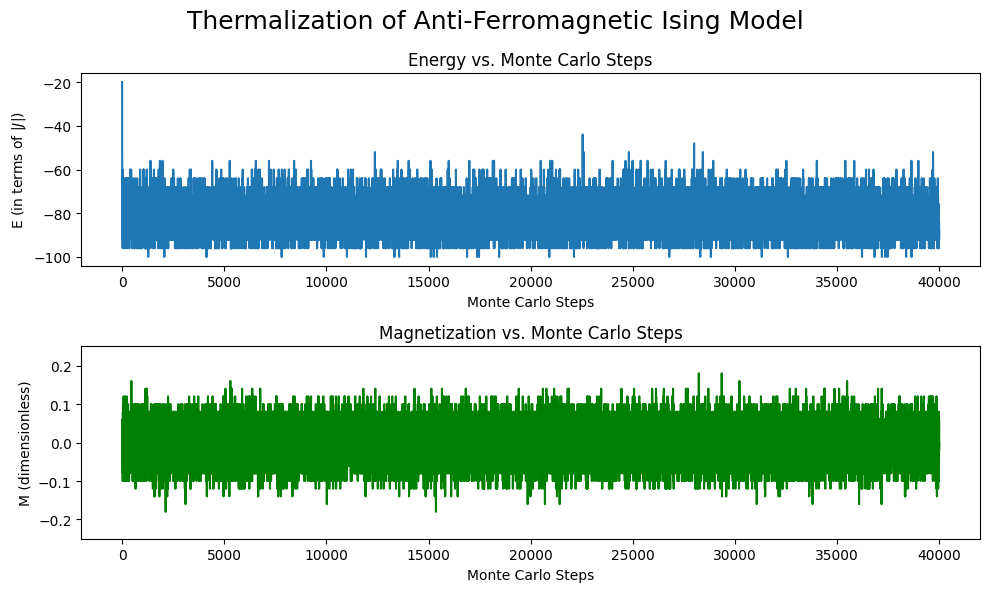

In [18]:
plt.figure(figsize=(10,6))
plt.suptitle('Thermalization of Anti-Ferromagnetic Ising Model', fontsize=18)

plt.subplot(211)
plt.plot(system2[1],'-')
plt.title('Energy vs. Monte Carlo Steps')
plt.xlabel('Monte Carlo Steps')
plt.ylabel('E (in terms of $|J|$)')

plt.subplot(212)
plt.plot(system2[2],'g-')
plt.title('Magnetization vs. Monte Carlo Steps')
plt.xlabel('Monte Carlo Steps')
plt.ylabel('M (dimensionless)')
plt.ylim(-0.25,0.25)

plt.tight_layout()
plt.show()

#### $\text{Monte Carlo Simulation}$

In [19]:
meanE = lambda E,k:np.mean(E[k:])
meanM = lambda Ms,k:np.mean(Ms[k:])
varE = lambda E,k:np.var(E[k:])
varM = lambda Ms,k:np.var(Ms[k:])

Cv = lambda E,T,k:1/T**2 * np.var(E[k:])
chi = lambda Ms,T,k:1/T * np.var(Ms[k:])

# Temperature range 0.5K to 7K
Ts = np.linspace(0.5,7,75)

meanEnergy2 = []
meanMagnetization2 = []
specific_heat2 = []
susceptibility2 = []

for i in tqdm(range(len(Ts))):
    # Values of constants
    n = 10
    J = +1
    B = 0
    T = Ts[i]
    
    # Total Monte Carlo Simulation Steps = 40000
    M = 40000
    # Taking the values after 20000 steps for thermalization
    k = 20000

    l = np.random.choice([-1,+1], size = (n,n))
    
    res = sweep(l,J,M,B,T)
    E = res[1]
    Ms = np.abs(res[2])
    
    meanEnergy2.append(meanE(E,k))
    meanMagnetization2.append(meanM(Ms,k))
    specific_heat2.append(Cv(E,T,k))
    susceptibility2.append(chi(Ms,T,k))

100%|██████████| 75/75 [01:06<00:00,  1.13it/s]


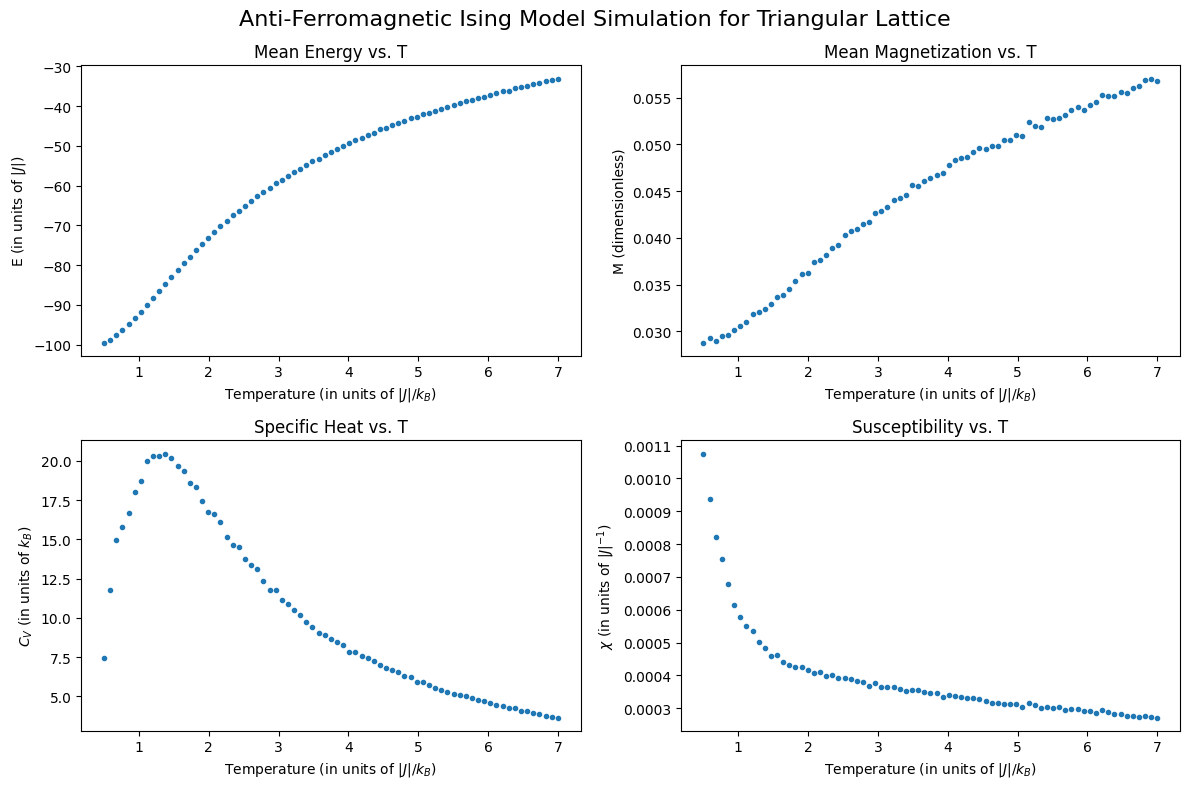

In [20]:
plt.figure(figsize=(12,8))
plt.suptitle("Anti-Ferromagnetic Ising Model Simulation for Triangular Lattice", fontsize=16)

plt.subplot(221)
plt.plot(Ts,meanEnergy2,'.')
plt.title('Mean Energy vs. T')
plt.xlabel('Temperature (in units of $|J|/k_B$)')
plt.ylabel('E (in units of $|J|$)')

plt.subplot(222)
plt.plot(Ts,meanMagnetization2,'.')
plt.title('Mean Magnetization vs. T')
plt.xlabel('Temperature (in units of $|J|/k_B$)')
plt.ylabel('M (dimensionless)')

plt.subplot(223)
plt.plot(Ts,specific_heat2,'.')
plt.title('Specific Heat vs. T')
plt.xlabel('Temperature (in units of $|J|/k_B$)')
plt.ylabel('$C_V$ (in units of $k_B$)')

plt.subplot(224)
plt.plot(Ts,susceptibility2,'.')
plt.title('Susceptibility vs. T')
plt.xlabel('Temperature (in units of $|J|/k_B$)')
plt.ylabel('$\chi$ (in units of $|J|^{-1}$)')

plt.tight_layout()
plt.savefig('AntiFerro.pdf', dpi=300)
plt.show()